# Understanding the relationships among characteristics of notable people

"Notability" is a social construct with no fixed definition.  The BHHT data contain four main attributes describing the notable people -- sex, occupation, birth era, region.  These characteristics can be used to understand the social construction of notability in different contexts.  For example, we can consider how the joint distribution of sex and occupation varies geographically (by region) and over time.

The characteristics of notable people in the BHHT data are nominal (except birth year, which can be recoded if desired to an ordinal "birth era" variable).  We can thus represent the data as a 4-way contingency table (sex x occupation x birth era x region). This contingency table reflects the joint distribution of the four characteristics in the population of interest.

In [43]:
import pandas as pd
import numpy as np
from pathlib import Path
import prince
import matplotlib.pyplot as plt

Modify the path below to point to the data file as needed.

In [44]:
pa = Path('/Users/liangqi/Library/Mobile Documents/com~apple~CloudDocs/Stats-504/bhht')

The entire dataset is around 2.3 million rows.  You can restrict to the first million rows when exploring, then switch to the whole dataset for final analyses.

In [45]:
ca = ["birth", "death", "gender", "un_region", "level1_main_occ", "name"]
df = pd.read_csv(pa / Path("cross-verified-database.csv.gz"), usecols=ca, encoding="latin-1")

Rename the variables so that they fit better as labels on plots.

In [46]:
df = df.rename({"level1_main_occ": "occ", "gender": "sex", "un_region": "reg"}, axis=1)
df = df[["birth", "occ", "sex", "reg", "name"]].dropna()

Since very few people in the dataset lived prior to 1500 we exclude them here.

In [47]:
df = df.query("birth >= 1500")
df.head()

,birth,occ,sex,reg,name
0,1932.0,Culture,Male,Europe,Claus_Hammel
1,1860.0,Culture,Male,Europe,Karel_MatÄj_Äapek-Chod
2,1971.0,Culture,Male,Europe,Florian_Eichinger
3,1983.0,Culture,Male,Europe,Florian_Jahr
4,1912.0,Leadership,Female,Europe,Wiltraut_Rupp-von_BrÃ¼nneck


Remove very infrequent or difficult to interpret categories

In [48]:
df = df.loc[df.occ != "Other", :]
df = df.loc[df.occ != "Missing", :]
df = df.loc[df.sex != "Other", :]

Create a "century of birth" variable, make it a string so that it is interpreted as a nominal variable.

In [49]:
df.loc[:, "era"] = df.birth.round(-2)
df = df.drop("birth", axis=1)
df.loc[:, "era"] = ["%d" % x for x in df.era]
df.head()

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



,occ,sex,reg,name,era
0,Culture,Male,Europe,Claus_Hammel,1900
1,Culture,Male,Europe,Karel_MatÄj_Äapek-Chod,1900
2,Culture,Male,Europe,Florian_Eichinger,2000
3,Culture,Male,Europe,Florian_Jahr,2000
4,Leadership,Female,Europe,Wiltraut_Rupp-von_BrÃ¼nneck,1900


We won't need the names anymore so we create a copy of the data that omits them.

In [50]:
dx = df.drop(columns=["name", 'reg'])
dx

,occ,sex,era
0,Culture,Male,1900
1,Culture,Male,1900
2,Culture,Male,2000
3,Culture,Male,2000
4,Leadership,Female,1900
...,...,...,...
2291812,Sports/Games,Male,2000
2291813,Sports/Games,Male,2000
2291814,Sports/Games,Male,2000
2291815,Culture,Male,2000


We will aim to understand notability by studying the contingency table below.

In [52]:
tab = dx.groupby(["sex", "occ", "era"]).size().unstack().fillna(0)
tab

era                         1500     1600     1700     1800      1900  \
sex    occ                                                              
Female Culture              96.0    440.0   1022.0   6464.0   63178.0   
       Discovery/Science    14.0     63.0    109.0   1014.0   15594.0   
       Leadership          459.0   1082.0   1242.0   3033.0   21444.0   
       Sports/Games          0.0      5.0      3.0     55.0    8307.0   
Male   Culture            2208.0   8053.0  11455.0  40808.0  223688.0   
       Discovery/Science  1837.0   4564.0   7352.0  31462.0  128151.0   
       Leadership         4626.0  14598.0  21665.0  95333.0  236982.0   
       Sports/Games         27.0     49.0    187.0   3657.0  154753.0   

era                           2000  
sex    occ                          
Female Culture             96247.0  
       Discovery/Science   11166.0  
       Leadership          24629.0  
       Sports/Games        72302.0  
Male   Culture            173341.0  
       Discovery/Science   38405.0  
       Leadership          85382.0  
       Sports/Games       366498.0

## Pearson residuals

One way to gain some insight from a multi-way contingency table is to form Pearson residuals.  These residuals have the form (observed - expected) / SD(observed), where "observed" and "expected" are the observed and expected cell counts for each cell in the contingency table.  The "expected" cell count is obtained under an independence model, and the standard deviation SD(observed) is calculated using the Poisson approximation to the distribution of a Bernoulli trial with small success probability.  The Pearson residuals help identify where the observed counts are furthest (in statistical terms) from what would be expected if the attributes were distributed randomly over the observations. 

In [31]:
long = tab.stack().reset_index().rename(columns={0: "count"})
n = long["count"].sum()
vx = ["sex", "reg", "occ", "era"]
vp = ["%s_p" % x for x in vx]
for v in vx:
    long[v+"_p"] = long.groupby(v)["count"].transform(np.sum) / n
long["exp"] = n * long[vp].prod(1)
long["chi2_resid"] = (long["count"] - long["exp"]) / np.sqrt(long["exp"])
long = long.sort_values(by="chi2_resid")
long

/var/folders/1m/g_2xpnh912g613fymwqbt4gr0000gn/T/ipykernel_40208/4266104949.py:6: FutureWarning: The provided callable <function sum at 0x103e25d00> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  long[v+"_p"] = long.groupby(v)["count"].transform(np.sum) / n
/var/folders/1m/g_2xpnh912g613fymwqbt4gr0000gn/T/ipykernel_40208/4266104949.py:6: FutureWarning: The provided callable <function sum at 0x103e25d00> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  long[v+"_p"] = long.groupby(v)["count"].transform(np.sum) / n
/var/folders/1m/g_2xpnh912g613fymwqbt4gr0000gn/T/ipykernel_40208/4266104949.py:6: FutureWarning: The provided callable <function sum at 0x103e25d00> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided cal

,sex,reg,occ,era,count,sex_p,reg_p,occ_p,era_p,exp,chi2_resid
209,Male,Europe,Leadership,2000,36335.0,0.834614,0.565797,0.257419,0.437695,105509.730645,-212.961560
213,Male,Europe,Sports/Games,1800,2856.0,0.834614,0.565797,0.305511,0.091690,26231.879031,-144.328883
94,Female,Europe,Sports/Games,1900,5043.0,0.165386,0.565797,0.305511,0.429690,24359.853424,-123.765343
203,Male,Europe,Discovery/Science,2000,23637.0,0.834614,0.565797,0.120890,0.437695,49549.837381,-116.410955
214,Male,Europe,Sports/Games,1900,82886.0,0.834614,0.565797,0.305511,0.429690,122931.293800,-114.214241
...,...,...,...,...,...,...,...,...,...,...,...
191,Male,Asia,Sports/Games,2000,45335.0,0.834614,0.088681,0.305511,0.437695,19626.747033,183.505211
206,Male,Europe,Leadership,1700,18615.0,0.834614,0.565797,0.257419,0.021701,5231.299766,185.042462
159,Male,America,Leadership,1800,31952.0,0.834614,0.281045,0.257419,0.091690,10978.896302,200.162798
143,Male,Africa,Sports/Games,2000,22403.0,0.834614,0.028205,0.305511,0.437695,6242.291922,204.544755


## Multiple Correspondence Analysis

Multiple Correspondence Analysis (MCA) is a type of factor analysis for categorical data. A common use of MCA is to produce biplots that can be used to visualize the joint distribution of several categorical variables. Here we use MCA to understand the relationships among the contingency table of chacateristics of the subjects in the BHHT data.

Below we fit factors to the data using multiple correspondence analysis (MCA).

In [53]:
mca = prince.MCA(n_components=3)
mca = mca.fit(dx)

We can make an interactive plot of the column coordinates (there are too many objects to plot):

In [54]:
mca.plot(dx, show_row_markers=False, show_row_labels=False)

alt.LayerChart(...)

We can make a more informative static version of this plot by coloring the levels of the same parent variable in a common color, and by connecting the points that correspond to ordered variables.

In [55]:
cols = {"occ": "orange", "sex": "purple", "era": "navy"}

def mca_plot(mca, df, cols, jx, jy):
    cc = mca.column_coordinates(df)
    xmin, xmax = cc.iloc[:, jx].min(), cc.iloc[:, jx].max()
    d = xmax - xmin
    xmin -= 0.1*d
    xmax += 0.1*d
    ymin, ymax = cc.iloc[:, jy].min(), cc.iloc[:, jy].max()
    d = ymax - ymin
    ymin -= 0.1*d
    ymax += 0.1*d

    plt.clf()
    plt.grid(True)
    for k in cols.keys():
        cx = cc[cc.index.str.startswith(k)]
        if k == "era":
            plt.plot(cx.iloc[:, jx], cx.iloc[:, jy], "-", color=cols[k])
        for i in range(cx.shape[0]):
            plt.text(cx.iloc[i, jx], cx.iloc[i, jy], cx.index[i], color=cols[k],
                     ha="center", va="center")
    plt.xlabel("Component %d" % (jx + 1))
    plt.ylabel("Component %d" % (jy + 1))
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)

The most informative projection of the columns is spanned by the first two factors, as plotted below:

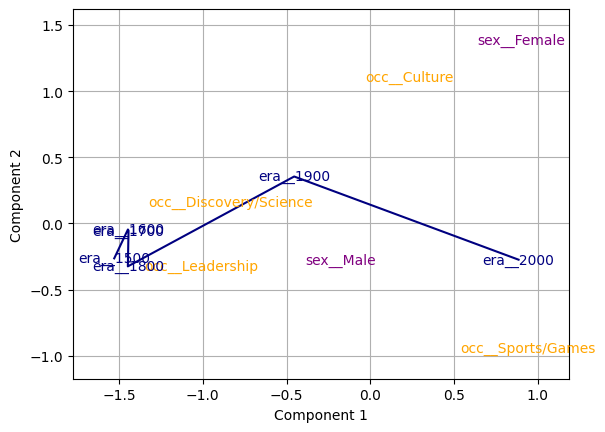

In [57]:
mca_plot(mca, dx, cols, 0, 1)
plt.savefig('biplot')

Recall that the angle between two vectors corresponding to categories of different variables encodes the correlation between the indicators for those variable categories.  This is illustrated by a few examples below.

In [36]:
np.corrcoef(dx.occ=="Culture", dx.sex=="Female")

array([[1.        , 0.18608777],
       [0.18608777, 1.        ]])

In [38]:
np.corrcoef(dx.occ=="Leadership", dx.sex=="Female")

array([[ 1.       , -0.1010067],
       [-0.1010067,  1.       ]])

In [39]:
np.corrcoef(dx.reg=="Oceania", dx.occ=="Sports/Games")

array([[1.        , 0.10044578],
       [0.10044578, 1.        ]])

In [40]:
np.corrcoef(dx.occ=="Leadership", dx.era=="1800")

array([[1.        , 0.20606912],
       [0.20606912, 1.        ]])

Below we plot factors 2 and 3 (these are the third and fourth factors since Python counts from zero).  These capture an independent projection of the data from factors 0 and 1.

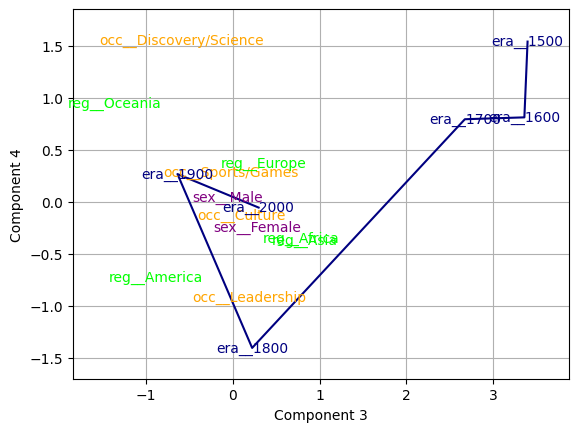

In [41]:
mca_plot(mca, dx, cols, 2, 3)

In an MCA plot, information about the variables is encoded both in the angles between variable scores, and in the magnitudes of the variable scores.  Variables that are uncorrelated with all other variables have very short magnitudes.  To demonstrate this, we create a variable that is independent of the others and include it in the MCA.

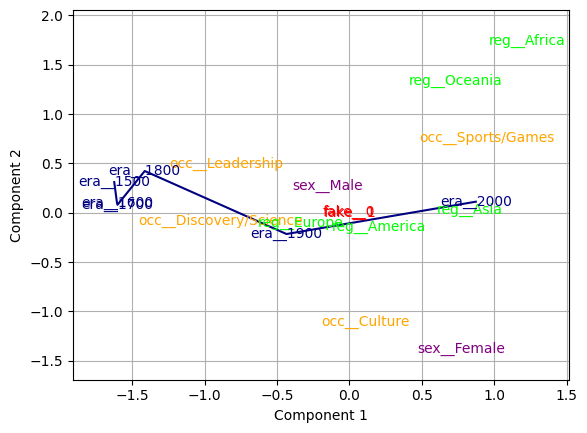

In [42]:
dx1 = dx.copy()
dx1["fake"] = np.random.choice([0, 1], dx.shape[0])
cols1 = cols.copy()
cols1["fake"] = "red"

mca1 = prince.MCA(n_components=4)
mca1 = mca1.fit(dx1)
mca1.transform(dx1)
mca_plot(mca1, dx1, cols1, 0, 1)